## Esercizio 2.1


_CONSEGNA_:

* Ispirandosi al text-tiling, implementare un algoritmo di segmentazione del
testo.


* Sfruttare informazioni come le frequenze e le co-occorrenze ed eventuale
pre-processing del testo.


_SVOLGIMENTO_:

* Breve lettura iniziale del seguente
  [articolo](https://www.sciencedirect.com/science/article/pii/S0031320316303399#bib12)


* Si è scelto di utilizzare un testo su Trump-wall già usato nella seconda
parte del corso come file d' ingresso


* Si crea per prima cosa il dizionario del testo, annotando le frequenze di
ogni parola (previo filtering e lemmatizzazione).


* Si creano poi i vettori che contengono i termini presenti in ogni frase.



* Si calcola la cosine similarity fra tutti questi vettori colonna.


* Si itera su queste cosine similarities per identificare i punti in cui il
valore scende al di sotto della loro media di una certa percentuale: in questi
punti viene inserito un punto di cambio di discorso.


* L' operazione viene ripetuta per un certo numero d' iterazioni, usando come
confronto la media di quel preciso segmento invece che la media complessiva.


* Come confronto ulteriore si usa implementazione di nltk del TextTiling disponibile [qui](https://www.nltk.org/_modules/nltk/tokenize/texttiling.html)

_RISULTATI_:

![2.1 - plot_1](output/Trump-wall.png "Trump wall segmentato con la cosine similarity")

![2.2 - plot_2](output/TexTiling_of_Trump-wall.png "Trump wall segmentato con l' algoritmo di libreria")

## Esercizio 2.2

_CONSEGNA_:

### Topic modeling

* Partendo da un corpus, estrarre i topics con LDA
 - Scelta a mano del numero di topic
 - Provare a ragionare sulla qualità
* Visualizzazione (opzionale) scelta di librerie di visualizzazione di dati testuali

_SVOLGIMENTO_:

In [71]:
import nltk
import re
import string
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
%matplotlib inline

from wordcloud import WordCloud, STOPWORDS

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [8]:
from nltk.corpus import stopwords
stopwords = stopwords.words('english')

### We will be using the 20-Newsgroups dataset for this exercise. This version of the dataset contains about 11k newsgroups posts from 20 different topics.

In [9]:
# Import Dataset
df = pd.read_json('input/newsgroups.json')

In [10]:
df.head()

,content,target,target_names
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7,rec.autos
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,comp.sys.mac.hardware
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4,comp.sys.mac.hardware
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,1,comp.graphics
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14,sci.space


In [11]:
#topics
print(df.target_names.unique())

['rec.autos' 'comp.sys.mac.hardware' 'comp.graphics' 'sci.space'
 'talk.politics.guns' 'sci.med' 'comp.sys.ibm.pc.hardware'
 'comp.os.ms-windows.misc' 'rec.motorcycles' 'talk.religion.misc'
 'misc.forsale' 'alt.atheism' 'sci.electronics' 'comp.windows.x'
 'rec.sport.hockey' 'rec.sport.baseball' 'soc.religion.christian'
 'talk.politics.mideast' 'talk.politics.misc' 'sci.crypt']


In [12]:
len(df.target_names.unique())

20

In [13]:
df['content']

0        From: lerxst@wam.umd.edu (where's my thing)\nS...
1        From: guykuo@carson.u.washington.edu (Guy Kuo)...
2        From: twillis@ec.ecn.purdue.edu (Thomas E Will...
3        From: jgreen@amber (Joe Green)\nSubject: Re: W...
4        From: jcm@head-cfa.harvard.edu (Jonathan McDow...
                               ...                        
11309    From: jim.zisfein@factory.com (Jim Zisfein) \n...
11310    From: ebodin@pearl.tufts.edu\nSubject: Screen ...
11311    From: westes@netcom.com (Will Estes)\nSubject:...
11312    From: steve@hcrlgw (Steven Collins)\nSubject: ...
11313    From: gunning@cco.caltech.edu (Kevin J. Gunnin...
Name: content, Length: 11314, dtype: object

In [14]:
#I pick the contents and put them into a list
data = []
for content in df['content']:
    data.append(content)

In [15]:
print(data[0])

From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----







In [16]:
#clean the data removing useless stuff
cleaned_data = []

for line in data:
        '''Make text lowercase, remove useless stuff'''
        line = line.lower() #lowercase   
        #line = re.sub('[%s]' % re.escape(string.punctuation), ' ', line) #remove punctuation
        line = re.sub('\S*@\S*\s?', '', line) #remove e-mails
        line = re.sub('\s+', ' ', line) #remove new lines
        line = re.sub("\'", '', line) #remove single quotes
        cleaned_data.append(line.strip())

In [17]:
print(cleaned_data[0])

from: (wheres my thing) subject: what car is this!? nntp-posting-host: rac3.wam.umd.edu organization: university of maryland, college park lines: 15 i was wondering if anyone out there could enlighten me on this car i saw the other day. it was a 2-door sports car, looked to be from the late 60s/ early 70s. it was called a bricklin. the doors were really small. in addition, the front bumper was separate from the rest of the body. this is all i know. if anyone can tellme a model name, engine specs, years of production, where this car is made, history, or whatever info you have on this funky looking car, please e-mail. thanks, - il ---- brought to you by your neighborhood lerxst ----


In [18]:
pprint(cleaned_data[0])

('from: (wheres my thing) subject: what car is this!? nntp-posting-host: '
 'rac3.wam.umd.edu organization: university of maryland, college park lines: '
 '15 i was wondering if anyone out there could enlighten me on this car i saw '
 'the other day. it was a 2-door sports car, looked to be from the late 60s/ '
 'early 70s. it was called a bricklin. the doors were really small. in '
 'addition, the front bumper was separate from the rest of the body. this is '
 'all i know. if anyone can tellme a model name, engine specs, years of '
 'production, where this car is made, history, or whatever info you have on '
 'this funky looking car, please e-mail. thanks, - il ---- brought to you by '
 'your neighborhood lerxst ----')


In [19]:
#tokenize with Gensim’s simple_preprocess()
def split_sentence(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))    

words1 = list(split_sentence(cleaned_data))

In [20]:
print(words1[0])

['from', 'wheres', 'my', 'thing', 'subject', 'what', 'car', 'is', 'this', 'nntp', 'posting', 'host', 'rac', 'wam', 'umd', 'edu', 'organization', 'university', 'of', 'maryland', 'college', 'park', 'lines', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'saw', 'the', 'other', 'day', 'it', 'was', 'door', 'sports', 'car', 'looked', 'to', 'be', 'from', 'the', 'late', 'early', 'it', 'was', 'called', 'bricklin', 'the', 'doors', 'were', 'really', 'small', 'in', 'addition', 'the', 'front', 'bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body', 'this', 'is', 'all', 'know', 'if', 'anyone', 'can', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'of', 'production', 'where', 'this', 'car', 'is', 'made', 'history', 'or', 'whatever', 'info', 'you', 'have', 'on', 'this', 'funky', 'looking', 'car', 'please', 'mail', 'thanks', 'il', 'brought', 'to', 'you', 'by', 'your', 'neighborhood', 'lerxst']


In [21]:
words2 = []
def split_sentence2(sentences):
    counter = 0
    for sentence in sentences:
        words2.append([])
        for word in sentence.split():
            if len(word) != 1:
                words2[counter].append(word)
        counter += 1

split_sentence2(cleaned_data)

In [22]:
print(words2[0])

['from:', '(wheres', 'my', 'thing)', 'subject:', 'what', 'car', 'is', 'this!?', 'nntp-posting-host:', 'rac3.wam.umd.edu', 'organization:', 'university', 'of', 'maryland,', 'college', 'park', 'lines:', '15', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'saw', 'the', 'other', 'day.', 'it', 'was', '2-door', 'sports', 'car,', 'looked', 'to', 'be', 'from', 'the', 'late', '60s/', 'early', '70s.', 'it', 'was', 'called', 'bricklin.', 'the', 'doors', 'were', 'really', 'small.', 'in', 'addition,', 'the', 'front', 'bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body.', 'this', 'is', 'all', 'know.', 'if', 'anyone', 'can', 'tellme', 'model', 'name,', 'engine', 'specs,', 'years', 'of', 'production,', 'where', 'this', 'car', 'is', 'made,', 'history,', 'or', 'whatever', 'info', 'you', 'have', 'on', 'this', 'funky', 'looking', 'car,', 'please', 'e-mail.', 'thanks,', 'il', '----', 'brought', 'to', 'you', 'by', 'your', 'neighborhoo

In [23]:
words1[0] == words2[0]

False

In [24]:
#what elements are different?
for i in words2[0]:
    if i not in words1[0]:
        print(i)

from:
(wheres
thing)
subject:
this!?
nntp-posting-host:
rac3.wam.umd.edu
organization:
maryland,
lines:
15
day.
2-door
car,
60s/
70s.
bricklin.
small.
addition,
body.
know.
name,
specs,
production,
made,
history,
car,
e-mail.
thanks,
----
----


- gensim.models.Phrases

Automatically detect common phrases – aka multi-word expressions, word n-gram collocations – from a stream of sentences.

In [25]:
from gensim.models.phrases import Phrases, Phraser, ENGLISH_CONNECTOR_WORDS

bigram = gensim.models.Phrases(words1, min_count=5, threshold=100, 
                              connector_words=ENGLISH_CONNECTOR_WORDS) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[words1], threshold=100, 
                               connector_words=ENGLISH_CONNECTOR_WORDS) 

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = Phraser(bigram)
trigram_mod = Phraser(trigram)

#example for data_words1
print(trigram_mod[bigram_mod[words1[0]]])

['from', 'wheres', 'my', 'thing', 'subject', 'what', 'car', 'is', 'this', 'nntp_posting_host', 'rac_wam_umd_edu', 'organization', 'university', 'of', 'maryland_college_park', 'lines', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'saw', 'the', 'other', 'day', 'it', 'was', 'door', 'sports', 'car', 'looked', 'to', 'be', 'from', 'the', 'late', 'early', 'it', 'was', 'called', 'bricklin', 'the', 'doors', 'were', 'really', 'small', 'in', 'addition', 'the', 'front_bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body', 'this', 'is', 'all', 'know', 'if', 'anyone', 'can', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'of', 'production', 'where', 'this', 'car', 'is', 'made', 'history', 'or', 'whatever', 'info', 'you', 'have', 'on', 'this', 'funky', 'looking', 'car', 'please', 'mail', 'thanks', 'il', 'brought', 'to', 'you', 'by', 'your', 'neighborhood', 'lerxst']


In [26]:
def remove_stopwords(text):
    '''Remove stopwords from text'''
    return [[w for w in simple_preprocess(str(content)) if w not in stopwords] for content in text]

def build_bigrams(text):
    '''construct bigrams from text '''
    return [bigram_mod[content] for content in text]

def build_trigrams(text):
    '''construct trigrams from text'''
    return [trigram_mod[bigram_mod[content]] for content in text]

def lemmatizer(text, pos=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """It assign general context to words in text 
       source: https://spacy.io/api/annotation"""
    output = []
    for s in text:
        content = nlp(" ".join(s)) 
        output.append([tkn.lemma_ for tkn in content if tkn.pos_ in pos])
    return output

In [27]:
# Remove Stop Words
words_cleaned = remove_stopwords(words1)

# Form Bigrams
words_bigrams = build_bigrams(words_cleaned)

#Form Trigrams
words_trigrams = build_trigrams(words_cleaned)

In [28]:
print(words_cleaned[0])
len(words_cleaned[0])

['wheres', 'thing', 'subject', 'car', 'nntp', 'posting', 'host', 'rac', 'wam', 'umd', 'edu', 'organization', 'university', 'maryland', 'college', 'park', 'lines', 'wondering', 'anyone', 'could', 'enlighten', 'car', 'saw', 'day', 'door', 'sports', 'car', 'looked', 'late', 'early', 'called', 'bricklin', 'doors', 'really', 'small', 'addition', 'front', 'bumper', 'separate', 'rest', 'body', 'know', 'anyone', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'production', 'car', 'made', 'history', 'whatever', 'info', 'funky', 'looking', 'car', 'please', 'mail', 'thanks', 'il', 'brought', 'neighborhood', 'lerxst']


65

In [29]:
print(words_bigrams[0])
len(words_bigrams[0])

['wheres', 'thing', 'subject', 'car', 'nntp_posting', 'host', 'rac_wam', 'umd_edu', 'organization', 'university', 'maryland_college', 'park', 'lines', 'wondering', 'anyone', 'could', 'enlighten', 'car', 'saw', 'day', 'door', 'sports', 'car', 'looked', 'late', 'early', 'called', 'bricklin', 'doors', 'really', 'small', 'addition', 'front_bumper', 'separate', 'rest', 'body', 'know', 'anyone', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'production', 'car', 'made', 'history', 'whatever', 'info', 'funky', 'looking', 'car', 'please', 'mail', 'thanks', 'il', 'brought', 'neighborhood', 'lerxst']


60

In [30]:
print(words_trigrams[0])
len(words_trigrams[0])

['wheres', 'thing', 'subject', 'car', 'nntp_posting_host', 'rac_wam_umd_edu', 'organization', 'university', 'maryland_college_park', 'lines', 'wondering', 'anyone', 'could', 'enlighten', 'car', 'saw', 'day', 'door', 'sports', 'car', 'looked', 'late', 'early', 'called', 'bricklin', 'doors', 'really', 'small', 'addition', 'front_bumper', 'separate', 'rest', 'body', 'know', 'anyone', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'production', 'car', 'made', 'history', 'whatever', 'info', 'funky', 'looking', 'car', 'please', 'mail', 'thanks', 'il', 'brought', 'neighborhood', 'lerxst']


57

In [32]:
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [33]:
# Do lemmatization keeping only noun, adj, vb, adv
lemmatization2 = lemmatizer(words_bigrams, pos=['NOUN', 'ADJ', 'VERB', 'ADV'])
print(lemmatization2[0])
len(lemmatization2[0])

['where', 's', 'thing', 'subject', 'car', 'nntp_poste', 'host', 'rac_wam', 'umd_edu', 'organization', 'university', 'maryland_college', 'park', 'line', 'wonder', 'enlighten', 'car', 'saw', 'day', 'door', 'sport', 'car', 'look', 'late', 'early', 'call', 'bricklin', 'door', 'really', 'small', 'addition', 'separate', 'rest', 'body', 'know', 'tellme', 'model', 'name', 'engine', 'spec', 'year', 'production', 'car', 'make', 'history', 'info', 'funky', 'look', 'car', 'mail', 'thank', 'bring', 'neighborhood', 'lerxst']


54

In [34]:
print(lemmatization2[1])
len(lemmatization2[1])

['subject', 'si', 'clock', 'poll', 'final', 'call', 'summary', 'final', 'call', 'si', 'clock', 'report', 'keyword', 'acceleration', 'clock', 'upgrade', 'article_shelley', 'innc', 'organization', 'university', 'washington', 'line', 'nntp_poste', 'edu', 'fair', 'number', 'brave', 'soul', 'upgrade', 'clock', 'oscillator', 'share', 'experience', 'poll', 'send', 'brief', 'message', 'detail', 'experience', 'procedure', 'top', 'speed', 'attain', 'cpu', 'rate', 'speed', 'add', 'card', 'adapter', 'heat_sink', 'hour', 'usage', 'day', 'floppy_disk', 'functionality', 'floppy', 'especially', 'request', 'summarize', 'day', 'add', 'network', 'knowledge', 'base', 'do', 'clock', 'upgrade', 'have', 'answer', 'poll', 'thank']


71

In [35]:
lemmatization3 = lemmatizer(words_trigrams, pos=['NOUN', 'ADJ', 'VERB', 'ADV'])
print(lemmatization3[0])
len(lemmatization3[0])

['where', 's', 'thing', 'subject', 'car', 'rac_wam_umd_edu', 'organization', 'university', 'line', 'wonder', 'enlighten', 'car', 'saw', 'day', 'door', 'sport', 'car', 'look', 'late', 'early', 'call', 'bricklin', 'door', 'really', 'small', 'addition', 'separate', 'rest', 'body', 'know', 'tellme', 'model', 'name', 'engine', 'spec', 'year', 'production', 'car', 'make', 'history', 'info', 'funky', 'look', 'car', 'mail', 'thank', 'bring', 'neighborhood', 'lerxst']


49

In [36]:
from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary

#Create Dictionary -> assign id to words
common_dictionary = Dictionary(lemmatization2)

#Create Corpus
#Term Document Frequency
common_corpus = [common_dictionary.doc2bow(text) for text in lemmatization2]

#Gensim creates a unique id for each word in the document. 
#The produced corpus shown above is a mapping of (word_id, word_frequency).
print(common_corpus[0])
len(common_corpus[0])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 5), (6, 1), (7, 2), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 2), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1)]


48

In [37]:
common_dictionary[0]

'addition'

In [38]:
#visualize dictionary
print([[(common_dictionary[i], f) for (i, f) in couple] for couple in common_corpus][0])

[('addition', 1), ('body', 1), ('bricklin', 1), ('bring', 1), ('call', 1), ('car', 5), ('day', 1), ('door', 2), ('early', 1), ('engine', 1), ('enlighten', 1), ('funky', 1), ('history', 1), ('host', 1), ('info', 1), ('know', 1), ('late', 1), ('lerxst', 1), ('line', 1), ('look', 2), ('mail', 1), ('make', 1), ('maryland_college', 1), ('model', 1), ('name', 1), ('neighborhood', 1), ('nntp_poste', 1), ('organization', 1), ('park', 1), ('production', 1), ('rac_wam', 1), ('really', 1), ('rest', 1), ('s', 1), ('saw', 1), ('separate', 1), ('small', 1), ('spec', 1), ('sport', 1), ('subject', 1), ('tellme', 1), ('thank', 1), ('thing', 1), ('umd_edu', 1), ('university', 1), ('where', 1), ('wonder', 1), ('year', 1)]


In [39]:
print(common_corpus[1])
len(common_corpus[1])

[(4, 2), (6, 2), (18, 1), (26, 1), (27, 1), (39, 1), (41, 1), (44, 1), (48, 1), (49, 1), (50, 2), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 5), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 2), (65, 1), (66, 2), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 1), (75, 1), (76, 1), (77, 1), (78, 1), (79, 1), (80, 3), (81, 1), (82, 1), (83, 1), (84, 1), (85, 1), (86, 1), (87, 2), (88, 1), (89, 2), (90, 1), (91, 1), (92, 1), (93, 3), (94, 1), (95, 1)]


56

In [40]:
#visualize dictionary
print([[(common_dictionary[i], f) for (i, f) in couple] for couple in common_corpus][1])

[('call', 2), ('day', 2), ('line', 1), ('nntp_poste', 1), ('organization', 1), ('subject', 1), ('thank', 1), ('university', 1), ('acceleration', 1), ('adapter', 1), ('add', 2), ('answer', 1), ('article_shelley', 1), ('attain', 1), ('base', 1), ('brave', 1), ('brief', 1), ('card', 1), ('clock', 5), ('cpu', 1), ('detail', 1), ('do', 1), ('edu', 1), ('especially', 1), ('experience', 2), ('fair', 1), ('final', 2), ('floppy', 1), ('floppy_disk', 1), ('functionality', 1), ('have', 1), ('heat_sink', 1), ('hour', 1), ('innc', 1), ('keyword', 1), ('knowledge', 1), ('message', 1), ('network', 1), ('number', 1), ('oscillator', 1), ('poll', 3), ('procedure', 1), ('rate', 1), ('report', 1), ('request', 1), ('send', 1), ('share', 1), ('si', 2), ('soul', 1), ('speed', 2), ('summarize', 1), ('summary', 1), ('top', 1), ('upgrade', 3), ('usage', 1), ('washington', 1)]


In [41]:
from gensim.models.ldamodel import LdaModel

# Train the model on the corpus.
lda = LdaModel(corpus=common_corpus, id2word=common_dictionary, num_topics=20, per_word_topics=True)

In [42]:
# Build LDA model changing some parameters. Source: https://radimrehurek.com/gensim/models/ldamodel.html
lda2 = gensim.models.ldamodel.LdaModel(corpus=common_corpus,
                                           id2word=common_dictionary,
                                           num_topics=20, 
                                           per_word_topics=True)

In [43]:
#Each topic is a combination of keywords which contributes a certain weightage to the topic itself.
pprint(lda.print_topics())

[(0,
  '0.018*"use" + 0.016*"drive" + 0.015*"line" + 0.015*"subject" + '
  '0.014*"organization" + 0.009*"card" + 0.009*"problem" + 0.008*"get" + '
  '0.008*"do" + 0.008*"window"'),
 (1,
  '0.013*"use" + 0.010*"line" + 0.010*"subject" + 0.009*"organization" + '
  '0.008*"window" + 0.007*"get" + 0.006*"write" + 0.006*"do" + 0.006*"server" '
  '+ 0.005*"system"'),
 (2,
  '0.008*"do" + 0.007*"write" + 0.007*"make" + 0.007*"people" + 0.006*"line" + '
  '0.006*"think" + 0.006*"subject" + 0.006*"organization" + 0.006*"say" + '
  '0.005*"know"'),
 (3,
  '0.013*"do" + 0.012*"say" + 0.010*"people" + 0.009*"write" + 0.009*"think" + '
  '0.008*"subject" + 0.008*"god" + 0.007*"line" + 0.007*"know" + '
  '0.007*"organization"'),
 (4,
  '0.787*"ax" + 0.058*"max" + 0.003*"ei" + 0.002*"vesa" + 0.002*"qax" + '
  '0.002*"mr" + 0.001*"_" + 0.001*"m" + 0.001*"qq" + 0.001*"fij"'),
 (5,
  '0.006*"canadian" + 0.006*"american" + 0.006*"line" + 0.005*"subject" + '
  '0.005*"city" + 0.005*"state" + 0.005*"organ

In [44]:
#Inferring the topic from the keywords

def extract_keywords(number):
    '''return a list of the (number) main words for each topic'''
    topic_list=[]
    l = lda.print_topics()
    result = [" ".join(x[1].strip('"') for x in sorted((e.split("*") for e in sl[1].split(" + ")),key=lambda x:float(x[0]),reverse=True)[:number]) for sl in l]
    for i in result:
        topic_list.append(i.split())
    return topic_list

topic_list = extract_keywords(8)
print(topic_list)

[['use', 'drive', 'line', 'subject', 'organization', 'card', 'problem', 'get'], ['use', 'line', 'subject', 'organization', 'window', 'get', 'write', 'do'], ['do', 'write', 'make', 'people', 'line', 'think', 'subject', 'organization'], ['do', 'say', 'people', 'write', 'think', 'subject', 'god', 'line'], ['ax', 'max', 'ei', 'vesa', 'qax', 'mr', '_', 'm'], ['canadian', 'american', 'line', 'subject', 'city', 'state', 'organization', 'vancouver'], ['faith', 'believe', 'god', 'subject', 'line', 'christian', 'koresh', 'organization'], ['file', 'program', 'use', 'image', 'line', 'window', 'entry', 'subject'], ['line', 'game', 'subject', 'organization', 'team', 'get', 'year', 'do'], ['player', 'write', 'article', 'organization', 'do', 'subject', 'well', 'alomar'], ['line', 'car', 'subject', 'organization', 'get', 'write', 'bike', 'look'], ['line', 'subject', 'organization', 'msg', 'det', 'tor', 'university', 'van'], ['armenian', 'greek', 'article', 'turk', 'write', 'subject', 'turkish', 'line']

In [57]:
from nltk.corpus import wordnet as wn

synsets = []
counter = 0

for j in topic_list:
    synsets.append([])
    for tp in topic_list[counter]:
        for ss in wn.synsets(str(tp)):
            for hypon in ss.hyponyms(): #trovo gli iponimi
                synsets[counter].append(hypon)
            for hyper in ss.hypernyms(): #trovo gli iponimi
                synsets[counter].append(hyper)
    counter += 1

### Output was trimmed for performance reasons

In [65]:
for synsList in synsets:
    print(synsList[:10])
    print("...........................")

[Synset('application.n.01'), Synset('exploitation.n.01'), Synset('misuse.n.01'), Synset('play.n.06'), Synset('practice.n.04'), Synset('recycling.n.01'), Synset('activity.n.01'), Synset('raison_d'etre.n.02'), Synset('utility.n.02'), Synset('utility.n.02')]
...........................
[Synset('application.n.01'), Synset('exploitation.n.01'), Synset('misuse.n.01'), Synset('play.n.06'), Synset('practice.n.04'), Synset('recycling.n.01'), Synset('activity.n.01'), Synset('raison_d'etre.n.02'), Synset('utility.n.02'), Synset('utility.n.02')]
...........................
[Synset('party.n.04'), Synset('solfa_syllable.n.01'), Synset('doctor's_degree.n.01'), Synset('overdo.v.01'), Synset('appear.v.06'), Synset('blaze_away.v.01'), Synset('carry.v.39'), Synset('churn_out.v.01'), Synset('click_off.v.01'), Synset('conduct.v.02')]
...........................
[Synset('party.n.04'), Synset('solfa_syllable.n.01'), Synset('doctor's_degree.n.01'), Synset('overdo.v.01'), Synset('appear.v.06'), Synset('blaze_a

In [46]:
from collections import Counter

#Try to infer the topic from keywords
def obtain_synset(synsets_list):
    max_value = 0
    counter = 0

    for hyp in synsets_list:
        counter += 1
        print("Topic " + str(counter))
        dic = Counter(hyp)
        for (key,value) in zip(dic.keys(),dic.values()):
            if value > max_value:
                max_value = value
        for (key,value) in zip(dic.keys(),dic.values()):
            if value == max_value:
                print(key,value)
        max_value = 0
        print()
                
obtain_synset(synsets)        

Topic 1
Synset('activity.n.01') 3
Synset('road.n.01') 3

Topic 2
Synset('activity.n.01') 3
Synset('communicate.v.02') 3
Synset('make.v.03') 3

Topic 3
Synset('make.v.03') 6

Topic 4
Synset('group.n.01') 3
Synset('think.v.03') 3

Topic 5
Synset('computer_memory_unit.n.01') 2

Topic 6
Synset('administrative_district.n.01') 3

Topic 7
Synset('belief.n.01') 2
Synset('institution.n.01') 2
Synset('person.n.01') 2
Synset('diagonal.n.03') 2
Synset('formation.n.01') 2
Synset('mark.n.04') 2
Synset('activity.n.01') 2

Topic 8
Synset('person.n.01') 3

Topic 9
Synset('activity.n.01') 3
Synset('time_period.n.01') 3

Topic 10
Synset('person.n.01') 3

Topic 11
Synset('compartment.n.02') 3
Synset('communicate.v.02') 3

Topic 12
Synset('diagonal.n.03') 2
Synset('formation.n.01') 2
Synset('mark.n.04') 2
Synset('activity.n.01') 2
Synset('person.n.01') 2
Synset('body.n.02') 2

Topic 13
Synset('indo-european.n.02') 2
Synset('artifact.n.01') 2
Synset('create_verbally.v.01') 2
Synset('communicate.v.02') 2
Syn

Model perplexity and topic coherence provide a convenient measure to judge how good a given topic model is.

In [47]:
# Compute Perplexity
# a measure of how good the model is. lower the better.
print('\nPerplexity: ', lda.log_perplexity(common_corpus))  

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda, texts=lemmatization2, dictionary=common_dictionary,
                                     coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -9.4992094755457

Coherence Score:  0.5499706880421493


# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

## Each document is composed of multiple topics. But, typically only one of the topics is dominant. The below code extracts this dominant topic for each sentence and shows the weight of the topic and the keywords in a nicely formatted output.

In [66]:
# Show dominant topic and its percentage of contribution in each document

def format_topics_sentences(ldamodel=None, corpus=common_corpus, texts=data):
    '''source: https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/'''
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda, corpus=common_corpus, texts=lemmatization2)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,8.0,0.6916,"line, game, subject, organization, team, get, ...","[where, s, thing, subject, car, nntp_poste, ho..."
1,1,0.0,0.5068,"use, drive, line, subject, organization, card,...","[subject, si, clock, poll, final, call, summar..."
2,2,8.0,0.2573,"line, game, subject, organization, team, get, ...","[thoma, willi, subject, pb, question, organiza..."
3,3,10.0,0.8376,"line, car, subject, organization, get, write, ...","[joe, green, subject, weitek, organization, ha..."
4,4,1.0,0.6792,"use, line, subject, organization, window, get,...","[jonathan, mcdowell, subject, shuttle_launch, ..."
5,5,13.0,0.3719,"gun, people, israel, state, right, law, write,...","[foxvog_dougla, subject, reword, second_amendm..."
6,6,1.0,0.8919,"use, line, subject, organization, window, get,...","[brian, manning, delaney, subject, brain, tumo..."
7,7,19.0,0.9463,"do, write, use, line, get, bit, subject, organ...","[grubb, subject, scsi, organization, state, un..."
8,8,7.0,0.5760,"file, program, use, image, line, window, entry...","[subject, win, icon, help, organization, unive..."
9,9,8.0,0.3100,"line, game, subject, organization, team, get, ...","[subject, sigma_design, double, article, organ..."


In [67]:
d = Counter(df_dominant_topic['Dominant_Topic'])
D = dict(sorted(d.items()))

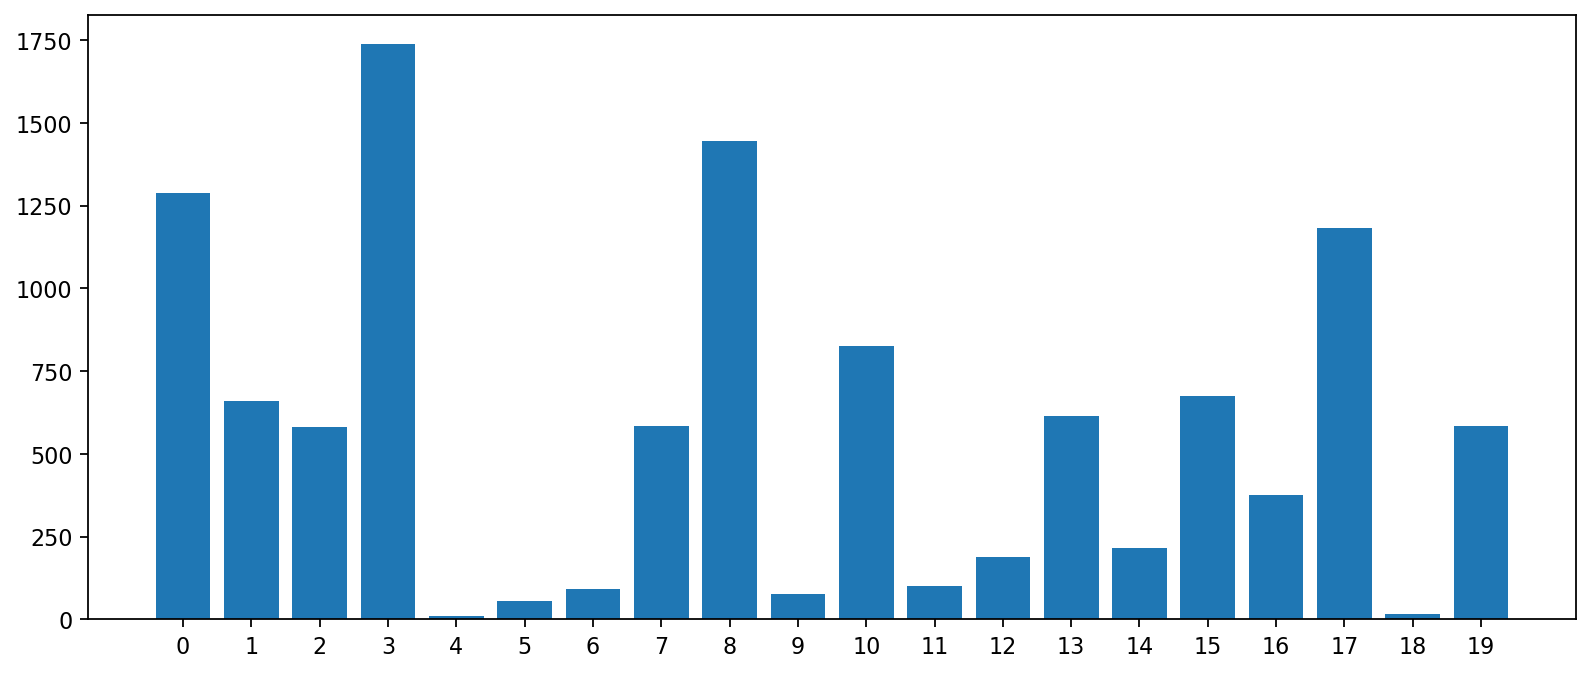

In [68]:
#Distribution of topics in the documents
plt.figure(figsize=(12,5), dpi=160)
plt.bar(range(len(D)), list(D.values()), align='center')
plt.xticks(range(len(D)), [i for i in range(20)])
# # for python 2.x:
# plt.bar(range(len(D)), D.values(), align='center')  # python 2.x
# plt.xticks(range(len(D)), D.keys())  # in python 2.x

plt.show()

In [69]:
# Represent the most representative sentence for each topic
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for (i, grp) in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.9892,"use, drive, line, subject, organization, card, problem, get, do, window","[john, rasper, subject, adcom, gtp, sensor, repeater, spec, organization, hp, colorado_spring, d..."
1,1.0,0.9947,"use, line, subject, organization, window, get, write, do, server, system","[david_rex, wood, subject, create, application, context, multiple, time, nntp_poste, host, bruno..."
2,2.0,0.9929,"do, write, make, people, line, think, subject, organization, say, know","[gregg_jaeger, subject, yet, organization, boston, university, line, article, write, article, gr..."
3,3.0,0.9952,"do, say, people, write, think, subject, god, line, know, organization","[joseph_dale, fisher, subject, tuff, christian, organization, indiana, university, line, article..."
4,4.0,0.9999,"ax, max, ei, vesa, qax, mr, _, m, qq, fij","[subject, cliff, reply, cliff, organization, university, line, part, max, ax, ax, ax, ax, ax, ax..."
5,5.0,0.9895,"canadian, american, line, subject, city, state, organization, vancouver, gary_dare, vote","[mark_wilson, subject, job, pork, bill, organization, ncr_engineere, line, d, wsj, start, white_..."
6,6.0,0.9884,"faith, believe, god, subject, line, christian, koresh, organization, child, write","[subject, davidian, compassion, reply, organization, amdahl_corporation, sunnyvale_ca, line, art..."
7,7.0,0.9858,"file, program, use, image, line, window, entry, subject, do, format","[mark, gregory, subject, avi, file, format, summary, avi, file, format, keyword, avi, file, form..."
8,8.0,0.9968,"line, game, subject, organization, team, get, year, do, go, write","[subject, nhl, summary_parse, result, game, play, sun, april, organization, university, line, ny..."
9,9.0,0.9635,"player, write, article, organization, do, subject, well, alomar, line, nhl","[gerald_olchowy, subject, plus_minus, stat, organization, university, department, line, meaningl..."


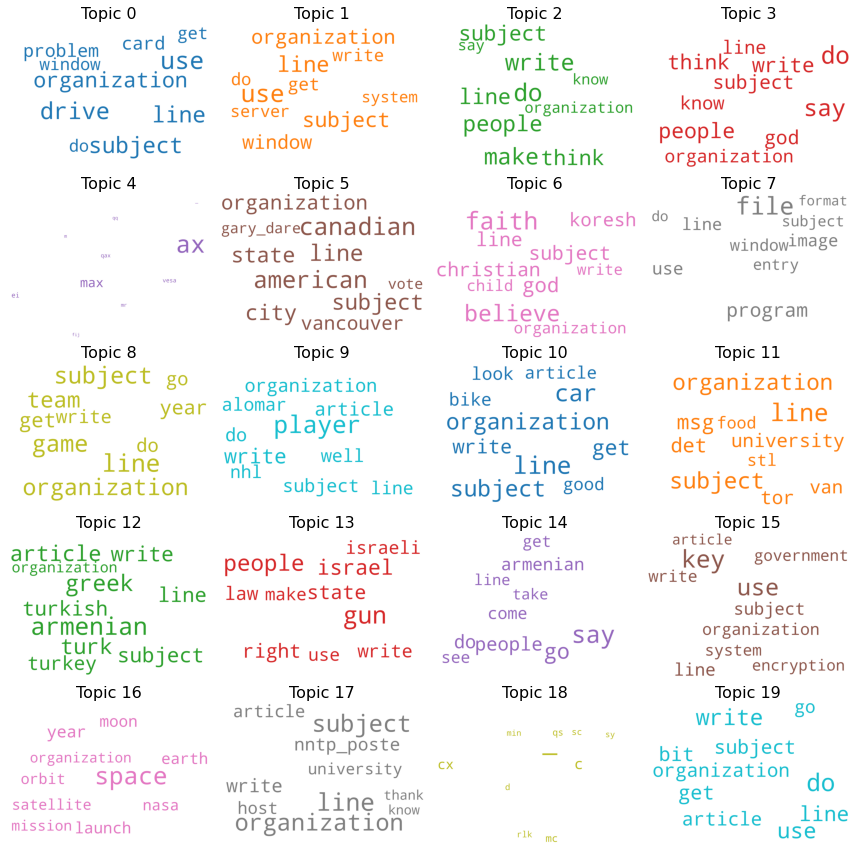

In [72]:
# Wordcloud of Top N words in each topic
# word cloud with the size of the words proportional to the weight
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stopwords,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab20',
                  color_func=lambda *args, **kwargs: cols[-10+i],
                  prefer_horizontal=1.0)

topics = lda.show_topics(formatted=False, num_topics=20)

fig, axes = plt.subplots(5, 4, figsize=(12,12), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()